In [56]:
import datetime as dt
import numpy as np
import shapely
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sys
import xgboost
from IPython.display import display


from ipywidgets import interactive
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import r2_score
from xgboost import XGBRegressor


sys.path.append('..') 
from src.data_preparation import compute_work_item_times, split_times
from src.evaluate import rmsle
from src.visualizations import plot_tree, plot_open_and_closed_tickets
%matplotlib inline
plt.style.use('fivethirtyeight')

from sklearn.model_selection import GridSearchCV   
from sklearn.preprocessing import MultiLabelBinarizer

In [57]:
## Pulling in the data and replacing NaNs
file_path = (r"C:\Users\ljeffery\Documents\Data Science Challenge\gdsc2_public.csv")
df = pd.read_csv(file_path, sep=';', parse_dates=['timestamp'])
df.from_phase.fillna('Start', inplace=True)  
df.to_phase.fillna('End', inplace=True)
df.components.fillna('', inplace=True)

In [58]:
df.head()

timestamp  work_item work_type work_priority    domain  platform  \
0 2015-01-02 14:39:14  WI_000001  WT_00001      WP_00003  BD_00001  PL_00001   
1 2015-01-02 15:04:20  WI_000002  WT_00002      WP_00004  BD_00002  PL_00002   
2 2015-01-02 15:28:22  WI_000003  WT_00002      WP_00004  BD_00002  PL_00002   
3 2015-01-02 15:33:54  WI_000004  WT_00002      WP_00004  BD_00002  PL_00002   
4 2015-01-02 16:32:11  WI_000005  WT_00002      WP_00003  BD_00003  PL_00003   

          components from_phase to_phase from_resource to_resource  
0                         Start  Analyze           NaN    ER_00043  
1  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225  
2  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225  
3  CO_00037/CO_00071      Start  Analyze           NaN    ER_00225  
4           CO_00113      Start  Analyze           NaN    ER_00206

In [59]:
## Checking that components is a string, and split it up into a list within the cell
df['components'] = df['components'].astype('str')
df['components_split'] = df['components'].str.split('/', -1, expand=False)

In [60]:
# One hot encode the components
mlb = MultiLabelBinarizer()
df_components = df.join(pd.DataFrame(mlb.fit_transform(df['components_split']), 
                          columns=mlb.classes_, index=df.index))
df_components = df_components.drop(['components_split','components', 'work_type', 'work_priority', 'domain', 'platform', 'to_resource', 'from_resource'], axis = 1)

In [61]:
df_components.head()

timestamp  work_item from_phase to_phase     CO_00001  CO_00002  \
0 2015-01-02 14:39:14  WI_000001      Start  Analyze  1         0         0   
1 2015-01-02 15:04:20  WI_000002      Start  Analyze  0         0         0   
2 2015-01-02 15:28:22  WI_000003      Start  Analyze  0         0         0   
3 2015-01-02 15:33:54  WI_000004      Start  Analyze  0         0         0   
4 2015-01-02 16:32:11  WI_000005      Start  Analyze  0         0         0   

   CO_00003  CO_00004  CO_00005  ...  CO_00168  CO_00169  CO_00170  CO_00171  \
0         0         0         0  ...         0         0         0         0   
1         0         0         0  ...         0         0         0         0   
2         0         0         0  ...         0         0         0         0   
3         0         0         0  ...         0         0         0         0   
4         0         0         0  ...         0         0         0         0   

   CO_00172  CO_00173  CO_00174  CO_00175  CO_00176  CO_00177  
0         0         0         0         0         0         0  
1         0         0         0         0         0         0  
2         0         0         0         0         0         0  
3         0         0         0         0         0         0  
4         0         0         0         0         0         0  

[5 rows x 172 columns]

In [62]:
## one hot encode everything else
one_hot_encode = ['work_type', 'work_priority', 'domain', 'platform']
df = df_components.join(pd.get_dummies(df[one_hot_encode]))

In [63]:
df.head()

timestamp  work_item from_phase to_phase     CO_00001  CO_00002  \
0 2015-01-02 14:39:14  WI_000001      Start  Analyze  1         0         0   
1 2015-01-02 15:04:20  WI_000002      Start  Analyze  0         0         0   
2 2015-01-02 15:28:22  WI_000003      Start  Analyze  0         0         0   
3 2015-01-02 15:33:54  WI_000004      Start  Analyze  0         0         0   
4 2015-01-02 16:32:11  WI_000005      Start  Analyze  0         0         0   

   CO_00003  CO_00004  CO_00005  ...  platform_PL_00010  platform_PL_00011  \
0         0         0         0  ...                  0                  0   
1         0         0         0  ...                  0                  0   
2         0         0         0  ...                  0                  0   
3         0         0         0  ...                  0                  0   
4         0         0         0  ...                  0                  0   

   platform_PL_00012  platform_PL_00013  platform_PL_00014  platform_PL_00015  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   platform_PL_00016  platform_PL_00017  platform_PL_00018  platform_PL_00019  
0                  0                  0                  0                  0  
1                  0                  0                  0                  0  
2                  0                  0                  0                  0  
3                  0                  0                  0                  0  
4                  0                  0                  0                  0  

[5 rows x 210 columns]

In [70]:
## begining of time function
sep_date_str = '01.01.2018'
times = compute_work_item_times(df)

In [31]:
closed_times['start'].isnull().sum()

0

In [32]:
times.head()

work_item               start                 end         duration  \
0  WI_000001 2015-01-02 14:39:14 2015-01-27 11:36:51 24 days 20:57:37   
1  WI_000002 2015-01-02 15:04:20 2015-01-14 09:46:37 11 days 18:42:17   
2  WI_000003 2015-01-02 15:28:22 2015-02-26 11:50:37 54 days 20:22:15   
3  WI_000004 2015-01-02 15:33:54 2015-01-28 09:11:05 25 days 17:37:11   
4  WI_000005 2015-01-02 16:32:11 2015-02-04 12:57:49 32 days 20:25:38   

   duration_in_days  duration_in_hours  duration_in_minutes  \
0             24.87             596.96             35817.62   
1             11.78             282.70             16962.28   
2             54.85            1316.37             78982.25   
3             25.73             617.62             37057.18   
4             32.85             788.43             47305.63   

   duration_in_seconds  
0            2149057.0  
1            1017737.0  
2            4738935.0  
3            2223431.0  
4            2838338.0

In [33]:
## removing outliers based on EDA
# times = times[np.abs(times.duration_in_seconds-times.duration_in_seconds.mean())<=(2*times.duration_in_seconds.std())]

In [71]:
## spliting the data up based on time calculated above
train_times, test_times, closed_times, open_times = split_times(times, sep_date_str)

train_work_items = set(train_times.work_item)  
test_work_items = set(test_times.work_item)  
open_work_items = set(open_times.work_item)
closed_work_items = set(closed_times.work_item)

df_start_only = df[df.from_phase == 'Start']
train_df = df_start_only[df_start_only.work_item.isin(train_work_items)]
test_df = df_start_only[df_start_only.work_item.isin(test_work_items)]
closed_df = df_start_only[df_start_only.work_item.isin(closed_work_items)]  
open_df = df_start_only[df_start_only.work_item.isin(open_work_items)]


In [87]:
open_times

work_item               start end duration  duration_in_days  \
164    WI_000165 2015-01-21 13:04:29 NaT      NaT               NaN   
195    WI_000196 2015-01-23 15:11:17 NaT      NaT               NaN   
263    WI_000264 2015-01-30 17:00:47 NaT      NaT               NaN   
272    WI_000273 2015-02-02 19:58:53 NaT      NaT               NaN   
277    WI_000278 2015-02-03 10:29:57 NaT      NaT               NaN   
297    WI_000298 2015-02-03 17:29:46 NaT      NaT               NaN   
395    WI_000396 2015-02-13 10:24:23 NaT      NaT               NaN   
468    WI_000469 2015-02-23 14:12:16 NaT      NaT               NaN   
491    WI_000492 2015-02-25 18:00:33 NaT      NaT               NaN   
501    WI_000502 2015-02-26 15:29:50 NaT      NaT               NaN   
511    WI_000512 2015-02-27 11:33:40 NaT      NaT               NaN   
582    WI_000583 2015-03-10 16:41:43 NaT      NaT               NaN   
613    WI_000614 2015-03-13 13:51:52 NaT      NaT               NaN   
640    WI_000641 2015-03-17 13:58:00 NaT      NaT               NaN   
770    WI_000771 2015-03-31 15:35:42 NaT      NaT               NaN   
824    WI_000825 2015-04-03 17:08:16 NaT      NaT               NaN   
846    WI_000847 2015-04-08 08:57:27 NaT      NaT               NaN   
870    WI_000871 2015-04-09 13:41:24 NaT      NaT               NaN   
871    WI_000872 2015-04-09 13:53:14 NaT      NaT               NaN   
872    WI_000873 2015-04-09 14:04:23 NaT      NaT               NaN   
890    WI_000891 2015-04-10 18:05:08 NaT      NaT               NaN   
930    WI_000931 2015-04-17 18:06:48 NaT      NaT               NaN   
962    WI_000963 2015-04-22 16:44:18 NaT      NaT               NaN   
1017   WI_001018 2015-04-30 14:54:59 NaT      NaT               NaN   
1021   WI_001022 2015-04-30 18:21:34 NaT      NaT               NaN   
1030   WI_001031 2015-05-04 11:27:34 NaT      NaT               NaN   
1036   WI_001037 2015-05-04 17:42:32 NaT      NaT               NaN   
1042   WI_001043 2015-05-05 17:40:49 NaT      NaT               NaN   
1067   WI_001068 2015-05-08 11:01:01 NaT      NaT               NaN   
1080   WI_001081 2015-05-11 16:15:25 NaT      NaT               NaN   
...          ...                 ...  ..      ...               ...   
11533  WI_011534 2018-03-29 11:18:53 NaT      NaT               NaN   
11534  WI_011535 2018-03-29 11:21:27 NaT      NaT               NaN   
11535  WI_011536 2018-03-29 14:48:21 NaT      NaT               NaN   
11536  WI_011537 2018-03-29 15:10:22 NaT      NaT               NaN   
11537  WI_011538 2018-03-29 15:15:36 NaT      NaT               NaN   
11538  WI_011539 2018-03-29 15:59:35 NaT      NaT               NaN   
11539  WI_011540 2018-03-29 16:28:26 NaT      NaT               NaN   
11540  WI_011541 2018-03-29 17:04:20 NaT      NaT               NaN   
11541  WI_011542 2018-03-29 20:11:46 NaT      NaT               NaN   
11542  WI_011543 2018-03-30 08:22:59 NaT      NaT               NaN   
11544  WI_011545 2018-03-30 08:59:10 NaT      NaT               NaN   
11545  WI_011546 2018-03-30 10:46:05 NaT      NaT               NaN   
11546  WI_011547 2018-03-30 11:18:40 NaT      NaT               NaN   
11547  WI_011548 2018-03-30 11:37:43 NaT      NaT               NaN   
11548  WI_011549 2018-03-30 12:03:03 NaT      NaT               NaN   
11549  WI_011550 2018-03-30 13:18:23 NaT      NaT               NaN   
11550  WI_011551 2018-03-30 13:33:06 NaT      NaT               NaN   
11551  WI_011552 2018-03-30 14:59:18 NaT      NaT               NaN   
11552  WI_011553 2018-03-30 15:18:29 NaT      NaT               NaN   
11553  WI_011554 2018-03-30 15:20:10 NaT      NaT               NaN   
11554  WI_011555 2018-03-30 15:29:55 NaT      NaT               NaN   
11555  WI_011556 2018-03-30 15:30:24 NaT      NaT               NaN   
11556  WI_011557 2018-03-30 15:31:18 NaT      NaT               NaN   
11557  WI_011558 2018-03-30 15:56:17 NaT      NaT               NaN   
11558  WI_011559 2018-03-30 16:

In [73]:
## Creating the features
train_features = train_df.drop(['timestamp', 'work_item', 'from_phase', 'to_phase'], axis=1)
test_features = test_df.drop(['timestamp', 'work_item', 'from_phase', 'to_phase'], axis=1)
open_features = open_df.drop(['timestamp', 'work_item', 'from_phase', 'to_phase'], axis=1)
closed_features = closed_df.drop(['timestamp', 'work_item', 'from_phase', 'to_phase'], axis=1)

In [74]:
## Creating the features
train_features = train_features.values
test_features = test_features.values
open_features = open_features.values
closed_features = closed_features.values

In [75]:
test_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [76]:
## Sanity check of the shape
closed_features.shape

(10522, 206)

C:\Users\ljeffery\AppData\Local\Continuum\anaconda2\envs\Py3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


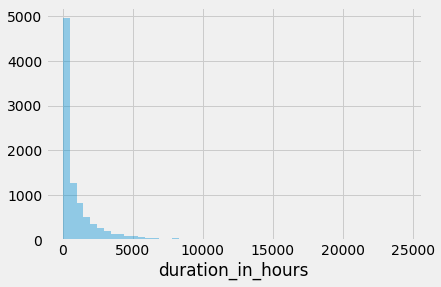

In [77]:
sns.distplot(train_times.duration_in_hours, kde = False)

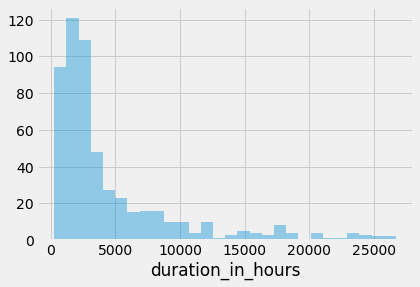

In [78]:
sns.distplot(test_times.duration_in_hours, kde = False)

In [79]:
## creation of functions used to get the models
def eval_model(model, parameters, train_features, train_times, test_features, test_times):
    regg = GridSearchCV(model, parameters, verbose = 1)
    regg.fit(train_features, train_times.duration_in_days)
    train_predictions = pd.DataFrame(train_times.work_item)  
    train_predictions['predictions'] = regg.predict(train_features)
    test_predictions = pd.DataFrame(test_times.work_item)
    test_predictions['predictions'] = regg.predict(test_features)
    train_rmsle = rmsle(train_times, train_predictions)
    test_rmsle = rmsle(test_times, test_predictions)
    best_parameters = regg.best_estimator_.get_params()
    return train_rmsle, test_rmsle, best_parameters, train_predictions, test_predictions

def eval_model2(model,train_features, train_times, test_features, test_times):
    model.fit(train_features, train_times.duration_in_days)
    train_predictions = pd.DataFrame(train_times.work_item)  
    train_predictions['predictions'] = model.predict(train_features)
    test_predictions = pd.DataFrame(test_times.work_item)
    test_predictions['predictions'] = model.predict(test_features)
    train_rmsle = rmsle(train_times, train_predictions)
    test_rmsle = rmsle(test_times, test_predictions)
    return train_rmsle, test_rmsle

In [80]:
## Model 1 XGBRegressor. 
## After removing outliers TRAIN: 1.63, TEST: 1.06
model = XGBRegressor()
parameters = {'n_estimators': [100], # default 100
                'max_depth': [3, 6],
                'gamma': [0, 0.1],
                'subsample': [0.9, 1],
                'reg_alpha': [0], # L1 regularization, default 0
                'reg_lambda': [1], # L2 regularization, default 1
                'learning_rate': [0.1],
                'nthread': [-1],
                'seed': [1]}
train_rmsle, test_rmsle, best_parameters, train_predictions, test_predictions= eval_model(model, parameters, train_features, train_times, test_features, test_times)
print("\n Train RMSLE:", train_rmsle, "\n Test RMSLE:", test_rmsle, "\n Best parameters:", best_parameters)

C:\Users\ljeffery\AppData\Local\Continuum\anaconda2\envs\Py3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  1.7min finished



 Train RMSLE: 1.7575452454537055 
 Test RMSLE: 1.264682504451219 
 Best parameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': -1, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 1, 'silent': True, 'subsample': 1}


Text(0.5, 0, 'Actual duration')

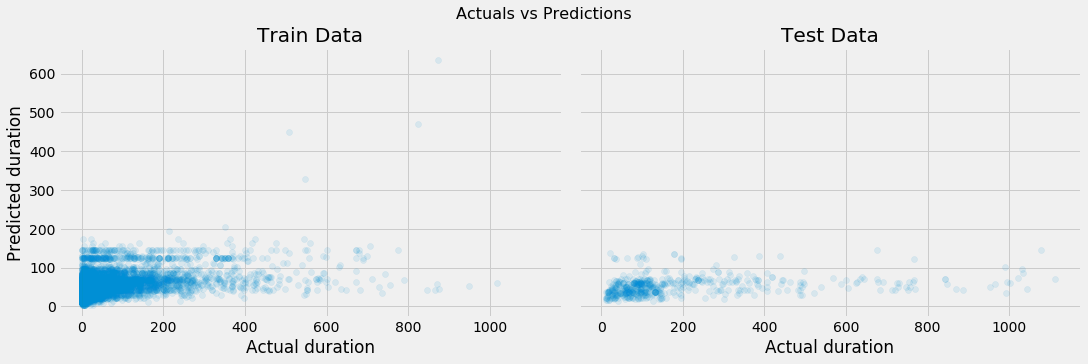

In [81]:
## ploting what the actuals and predictions look like 
fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(15,5), sharey=True, sharex=True)
fig.suptitle('Actuals vs Predictions', fontsize=16)
axs[0].scatter(x=train_times.duration_in_days, y=train_predictions.predictions, alpha=0.1)
axs[0].set_title('Train Data')
axs[0].set_xlabel('Actual duration')
axs[0].set_ylabel('Predicted duration')
axs[1].scatter(x=test_times.duration_in_days, y=test_predictions.predictions, alpha=0.1)
axs[1].set_title('Test Data')
axs[1].set_xlabel('Actual duration')

In [88]:
def final_model(model, parameters, closed_features, closed_times, open_features, open_times):
    regg = GridSearchCV(model, parameters, verbose = 1)
    reg.fit(closed_features, y_closed)
    closed_predictions = pd.DataFrame(closed_times.work_item)  
    closed_predictions['predictions'] = model.predict(closed_features)
    open_predictions = pd.DataFrame(open_times.work_item)
    open_predictions['predictions'] = model.predict(open_features)
    closed_rmsle = rmsle(closed_times, closed_predictions)
    best_parameters = regg.best_estimator_.get_params()
#     open_rmsle = rmsle(open_times, open_predictions)
    
    return closed_rmsle, open_predictions, best_parameters



In [89]:
# model = XGBRegressor(max_depth = 3, learning_rate = 0.01, n_estimators = 1000,  n_jobs = 4, min_child_weight = 4)
model = XGBRegressor()
parameters = {'booster': ['gbtree'],
              'n_jobs':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.01, 0.01], #so called `eta` value
              'max_depth': [3],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.5, 0.9],
              'colsample_bytree': [0.5],
              'n_estimators': [1000], 
              'gamma' : [0, 0.1],
             }
# 
# train_rmsle, test_rmsle, best_parameters, train_predictions, test_predictions = eval_model(model, parameters, train_features, train_times, test_features, test_times)
closed_rmsle, open_predictions, best_parameters= final_model(model,closed_features, closed_times, open_features, open_times)

print("\n Closed RMSLE:", closed_rmsle, '\n Best Features:', best_features)
with open('open_predictions_knn_wt_wp.csv', 'w') as f:
    open_predictions.to_csv(f, index=False)

TypeError: final_model() missing 1 required positional argument: 'open_times'

In [43]:
# ## Model 2 KNeighboursRegressor
# model = KNeighborsRegressor()
# parameters = {'n_neighbors': (3,5,7),'leaf_size' : (20, 30, 50)}
# # test_predictions = eval_model(model, parameters, train_features, train_times, test_features, test_times)
# train_rmsle, test_rmsle, best_parameters, train_predictions, test_predictions = eval_model(model, parameters, train_features, train_times, test_features, test_times)
# print(train_rmsle, test_rmsle, best_parameters)

# ## Model 3 SVR
# model = SVR()
# parameters = {'kernel' : ('linear', 'poly', 'rbf')}
# train_rmsle, test_rmsle, best_parameters, train_predictions, test_predictions = eval_model(model, parameters, train_features, train_times, test_features, test_times)
# print(train_rmsle, test_rmsle, best_parameters)

C:\Users\ljeffery\AppData\Local\Continuum\anaconda2\envs\Py3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:  5.2min finished


1.5472093837069822 1.284793696606779 {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}
